# Sentiment Analysis Data Analysis

The goal of this project is to create a general purpose sentiment analysis tool, where a user can input any text, and get its sentiment in three possible ways:
* positive or negative
* 1 to 5 stars
* float number between 0 and 1

In [81]:
from typing import Dict
import os
os.environ['HF_DATASETS_OFFLINE'] = "1"
from datasets import load_dataset, Dataset, concatenate_datasets

import pandas as pd
from transformers import AutoTokenizer

import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set_style("whitegrid")

Readily available datasets are used, from the _datasets_ library. The selected datasets are free to use for any purpose (even commercial).

In [2]:
sa_datasets: Dict[str, Dataset] = {}

sa_datasets['sst'] = load_dataset("sst")
sa_datasets['ds_imdb'] = load_dataset("imdb")
sa_datasets['movrat'] = load_dataset("movie_rationales")
sa_datasets['tweet'] = load_dataset("tweet_eval", "sentiment")
sa_datasets['rotten'] = load_dataset("rotten_tomatoes")
sa_datasets['amzpol'] = load_dataset("amazon_polarity")

# sa_datasets['amazon'] = load_dataset("amazon_reviews_multi", "en")   # cannot use for money ever
# sa_datasets['yelp'] = load_dataset("yelp_review_full") # cannot use for money ever
# sa_datasets['financ'] = load_dataset("financial_phrasebank", "sentences_75agree")  # Must ask for commercial license

Using the latest cached version of the module from /home/alberto/.cache/huggingface/modules/datasets_modules/datasets/sst/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff (last modified on Wed Dec  7 12:15:41 2022) since it couldn't be found locally at sst.
No config specified, defaulting to: sst/default
Found cached dataset sst (/home/alberto/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
100%|██████████| 3/3 [00:00<00:00, 20.66it/s]
Using the latest cached version of the module from /home/alberto/.cache/huggingface/modules/datasets_modules/datasets/imdb/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1 (last modified on Wed Dec  7 11:12:00 2022) since it couldn't be found locally at imdb.
Found cached dataset imdb (/home/alberto/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
100%|██████████| 3/3 [00:00<00:00, 101.71it/s]


I want to see what the datasets are composed of: max, min, mean and median length of texts for each dataset (in terms of tokens).

In [3]:
max_num_tokens = 512
tokenizer_xlm = AutoTokenizer.from_pretrained("xlm-roberta-base", model_max_length=max_num_tokens, truncation=True)
tokenizer_xlnet = AutoTokenizer.from_pretrained("xlnet-large-cased", model_max_length=max_num_tokens, truncation=True)

In [25]:
def get_num_tokens(tokens):
    return len(tokens.encodings[0].ids)

def concat_title_content(list_fields):
    return

sa_dataframe = pd.DataFrame()

for ds_name, ds in sa_datasets.items():
    print(f'Processing {ds_name} dataset.')
    # Get all for analysis: train, test, val etc.
    # df = concatenate_datasets([ds[split] for split in ds.column_names.keys()]).to_pandas()
    datasets_to_concat = [ds[split] for split in ds.column_names.keys()]
    ds_full = concatenate_datasets(datasets_to_concat)

    # Get all relevant text in 'text' column
    if ds_name in ['sst', 'financ']:
        ds_full = ds_full.rename_column("sentence", "text")
    elif ds_name == 'movrat':
        ds_full = ds_full.rename_column("review", "text")
    elif ds_name == 'amzpol':

        df = ds_full.to_pandas()
        titles_with_punct = df['title'].str.endswith(('.','!','?'))
        df.loc[~titles_with_punct, 'title'] += '. '
        df.loc[titles_with_punct, 'title'] += ' '
        df['text'] = df['title'] + df['content']
        ds_full = Dataset.from_pandas(df)


    print("Extracting tokens...")
    ds_full = ds_full.map(lambda rows: tokenizer_xlm(rows['text']), batched=True)
    # ds_full = ds_full.map(lambda rows: tokenizer_xlnet(rows['text']), batched=True)

    df: pd.DataFrame = ds_full.to_pandas()

    df_num_tokens = pd.DataFrame({ds_name: df['input_ids'].map(lambda x: x.size)})
    sa_dataframe = pd.concat([sa_dataframe,df_num_tokens], axis=1)

    print(f'Dataset {ds_name} processed.')
    print()

Processing sst dataset.
Extracting tokens...


 92%|█████████▏| 11/12 [00:01<00:00,  8.72ba/s]


Dataset sst processed.

Processing ds_imdb dataset.
Extracting tokens...


 99%|█████████▉| 99/100 [00:47<00:00,  2.07ba/s]


Dataset ds_imdb processed.

Processing amzpol dataset.
Extracting tokens...


100%|█████████▉| 3999/4000 [12:25<00:00,  5.37ba/s]  


Dataset amzpol processed.

Processing movrat dataset.
Extracting tokens...


 50%|█████     | 1/2 [00:04<00:04,  4.43s/ba]


Dataset movrat processed.

Processing tweet dataset.
Extracting tokens...


 98%|█████████▊| 59/60 [00:06<00:00,  8.65ba/s]


Dataset tweet processed.

Processing rotten dataset.
Extracting tokens...


 91%|█████████ | 10/11 [00:00<00:00, 17.33ba/s]


Dataset rotten processed.



In [82]:
sa_dataframe.describe()

,sst,ds_imdb,amzpol,movrat,tweet,rotten
count,11855.00,100000.00,4000000.00,1999.00,59899.00,10662.00
mean,29.12,335.63,110.00,1029.21,30.61,32.83
std,12.81,252.84,59.46,446.52,8.80,13.40
min,4.00,10.00,19.00,26.00,3.00,3.00
25%,19.00,178.00,60.00,729.00,25.00,23.00
50%,28.00,249.00,98.00,968.00,31.00,32.00
75%,38.00,409.00,150.00,1235.50,36.00,42.00
max,75.00,3844.00,584.00,3979.00,118.00,84.00


<AxesSubplot: >

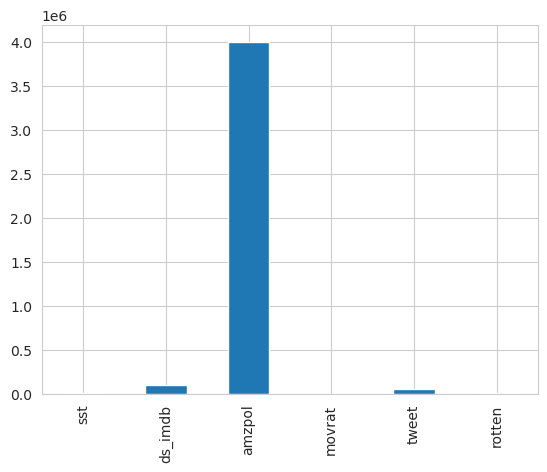

In [83]:
sa_dataframe.count().plot.bar()

<AxesSubplot: >

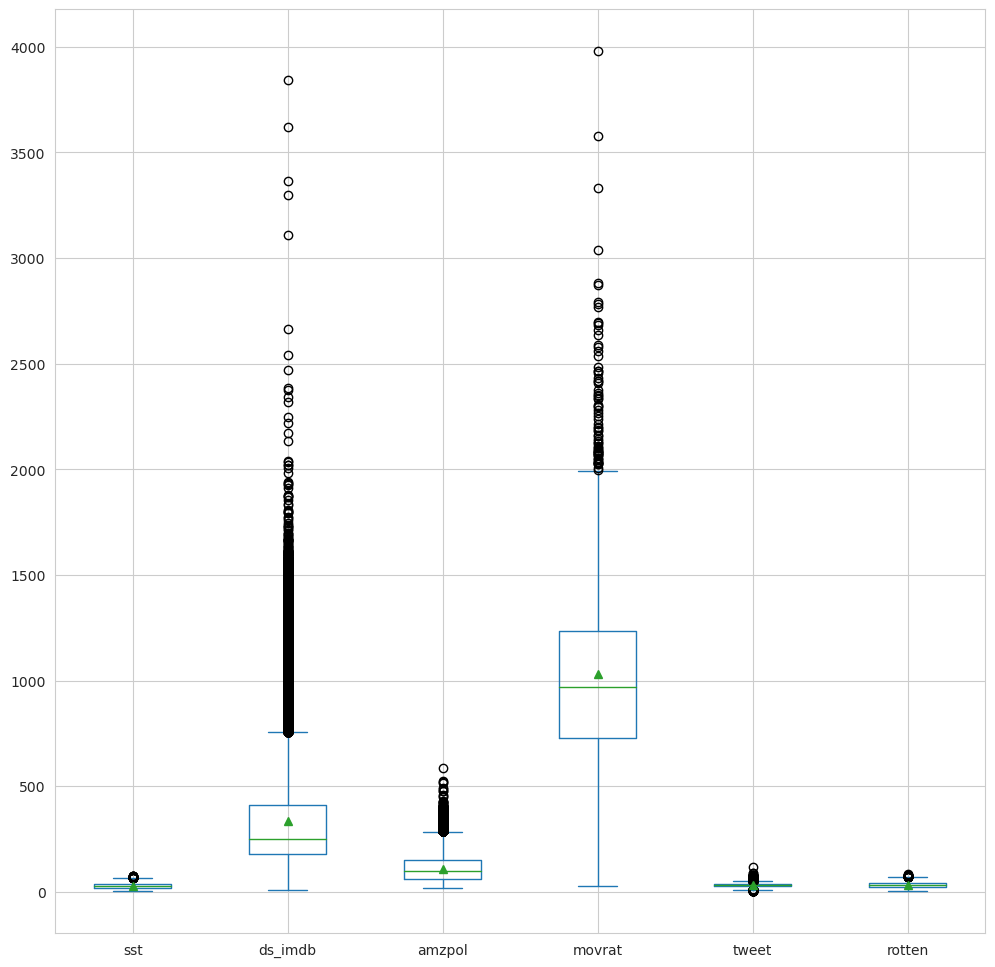

In [66]:
sa_dataframe.plot.box(figsize=(12,12), showmeans=True)

sst           AxesSubplot(0.125,0.11;0.110714x0.77)
ds_imdb    AxesSubplot(0.257857,0.11;0.110714x0.77)
amzpol     AxesSubplot(0.390714,0.11;0.110714x0.77)
movrat     AxesSubplot(0.523571,0.11;0.110714x0.77)
tweet      AxesSubplot(0.656429,0.11;0.110714x0.77)
rotten     AxesSubplot(0.789286,0.11;0.110714x0.77)
dtype: object

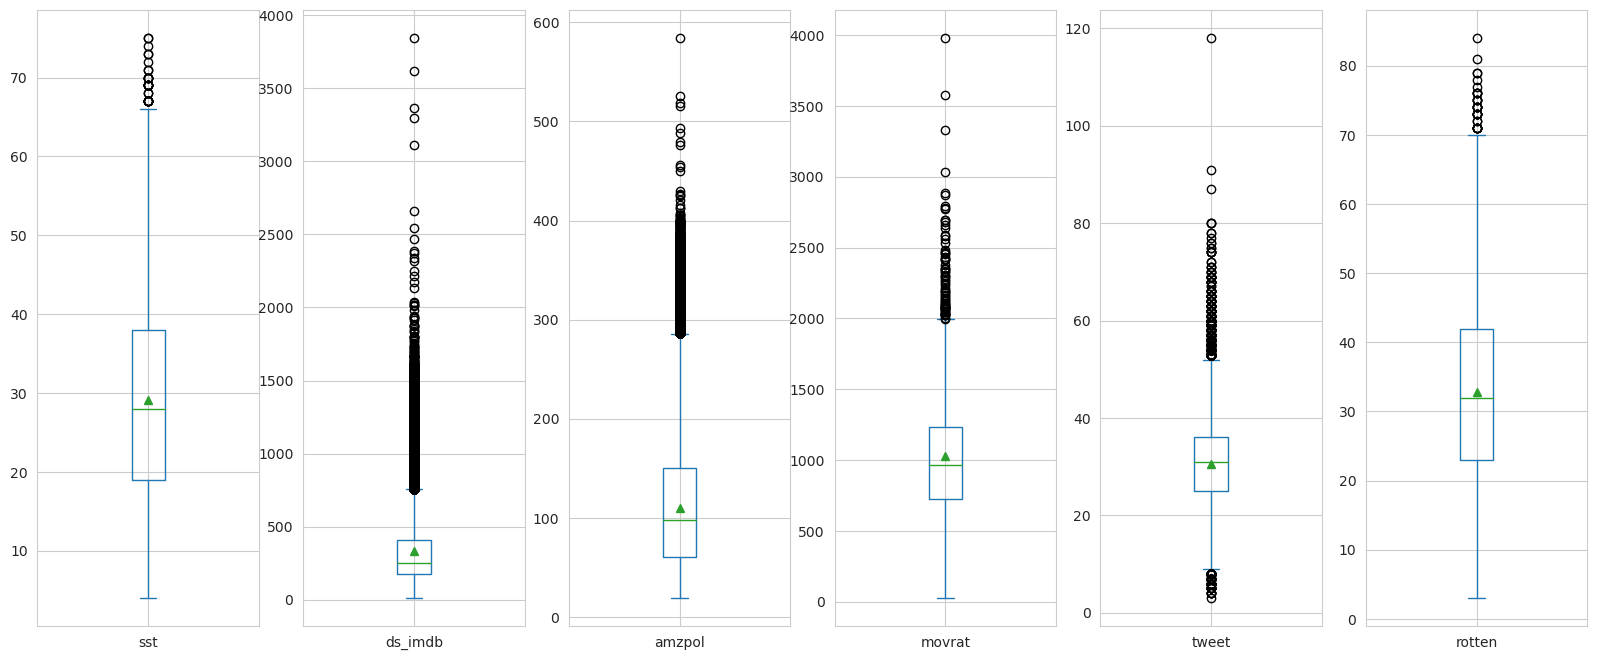

In [70]:
sa_dataframe.plot.box(subplots=True, figsize=(20,8), showmeans=True)

array([<AxesSubplot: ylabel='Density'>, <AxesSubplot: ylabel='Density'>,
       <AxesSubplot: ylabel='Density'>, <AxesSubplot: ylabel='Density'>,
       <AxesSubplot: ylabel='Density'>, <AxesSubplot: ylabel='Density'>],
      dtype=object)

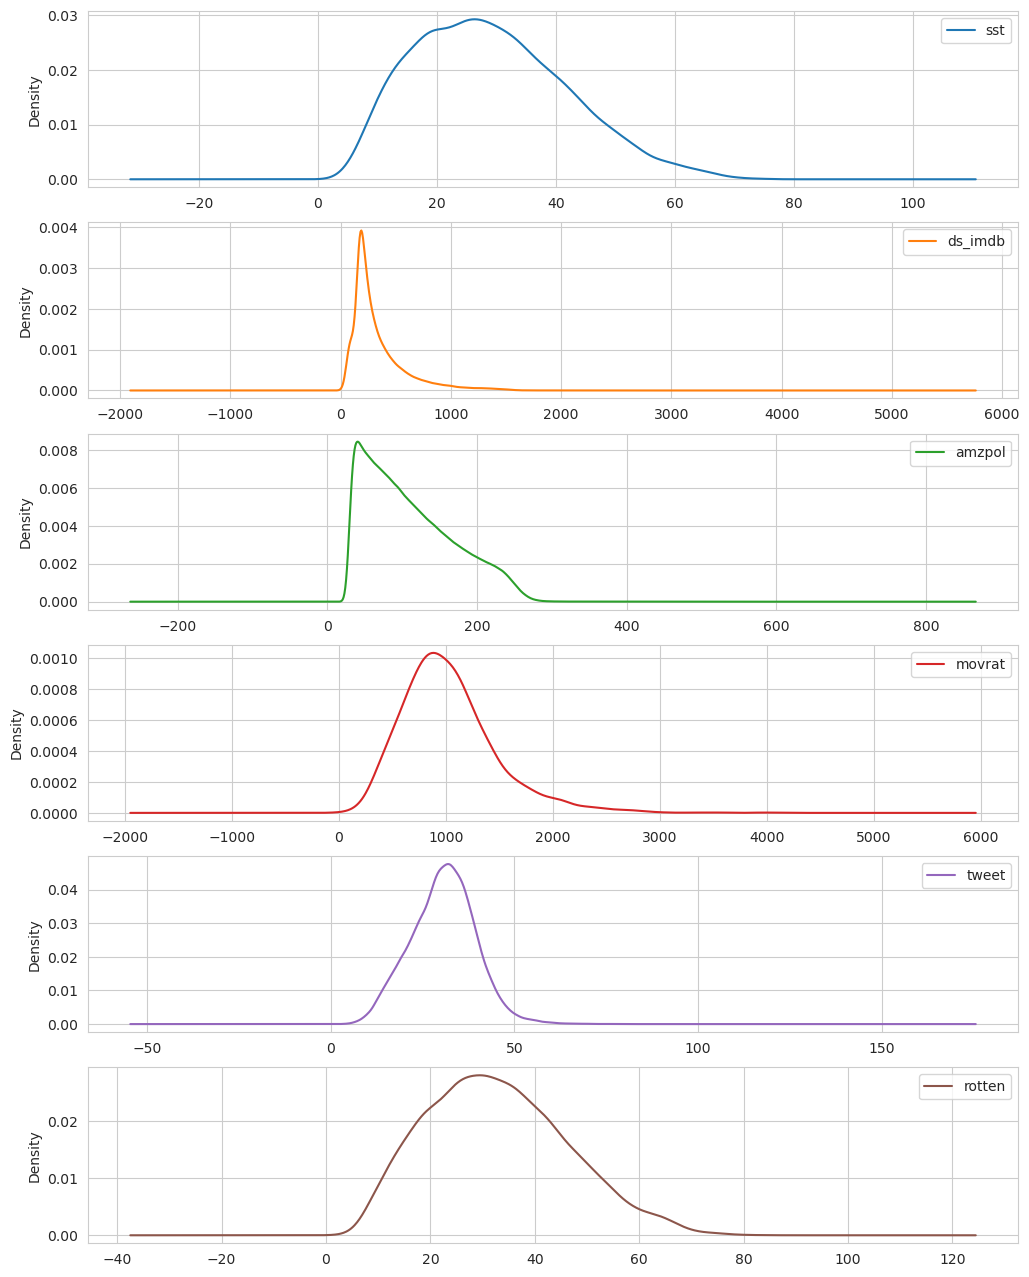

In [84]:
sa_dataframe.plot.density(subplots=True, sharex=False, figsize=(12, 16))